# Tensors

In [1]:
import torch

A = torch.tensor([[1.0, 2],[3,4]])
b = torch.tensor([5.,6])

print(A)
print(b)

tensor([[1., 2.],
        [3., 4.]])
tensor([5., 6.])


$$
A*x=b, => x=A^{-1}*b
$$

In [2]:
A_inv = torch.inverse(A)

# torch.linalg.matmul(A_inv, A)
x = torch.linalg.matmul(A_inv,b)
x

tensor([-4.0000,  4.5000])

In [3]:
torch.linalg.solve(A,b)

tensor([-4.0000,  4.5000])

In [4]:
# checkup
torch.linalg.matmul(A,x) - b

tensor([0., 0.])

In [5]:
A[:,0]

tensor([1., 3.])

In [6]:
A[1,:]

tensor([3., 4.])

In [7]:
A[A>3]

tensor([4.])

In [8]:
A*A.T

tensor([[ 1.,  6.],
        [ 6., 16.]])

# Autogradient

$$
\begin{align}
Q=3*a^{3}-b^{2} \\
\frac{\partial Q}{\partial a}=9*a^2 \\
\frac{\partial Q}{\partial b}=-2*b
\end{align}
$$

## use .backward(), if output only csalar

In [1]:
import torch

a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([4.], requires_grad=True)

Q = 3*a**3 - b**2

In [2]:
Q.backward()

/home/kimve/.local/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [3]:
a.grad

tensor([9.])

In [4]:
b.grad

tensor([-8.])

## use .grad(), if output may be vector or matrix

In [5]:
import torch

a = torch.tensor([[1.,2.],[3.,4.]], requires_grad=True)
b = torch.tensor([[4.,5.],[6.,7.]], requires_grad=True)

Q = 3*a**3 - b**2
print(a)
print(b)
print(Q)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[4., 5.],
        [6., 7.]], requires_grad=True)
tensor([[-13.,  -1.],
        [ 45., 143.]], grad_fn=<SubBackward0>)


In [6]:
torch.ones_like(a)

tensor([[1., 1.],
        [1., 1.]])

In [7]:
# calc gradient Q as matrix dQ/da with coeficient 1
dQ_da = torch.autograd.grad(Q, a, grad_outputs=torch.ones_like(a), create_graph=True)

In [8]:
dQ_da

(tensor([[  9.,  36.],
         [ 81., 144.]], grad_fn=<MulBackward0>),)

In [9]:
dQ_db = torch.autograd.grad(Q, b, grad_outputs=torch.ones_like(b))

In [10]:
dQ_db

(tensor([[ -8., -10.],
         [-12., -14.]]),)

In [11]:
# d^2Q/da^2
d2Q_da2 = torch.autograd.grad(dQ_da, a, grad_outputs=torch.ones_like(a))

In [12]:
d2Q_da2

(tensor([[18., 36.],
         [54., 72.]]),)

## Checkup

In [13]:
from sympy import symbols, diff

x = symbols('x')
y = symbols('y')

W = 3*x**3 - y**2
dW_dx = diff(W,x)
dW_dx

9*x**2

In [14]:
dW_dy = diff(W,y)
dW_dy

-2*y

In [15]:
dW_dx.subs({x: 1.})

9.00000000000000

In [16]:
dW_dy.subs({y: 4.})

-8.00000000000000

## Jacobian

## use torch.autograd.grad()

In [17]:
import torch

x = torch.tensor([1.,2.], requires_grad=True)
z = torch.stack([ x[0]**2 + x[1]**3, x[0]**3 + x[1]**2])
z

tensor([9., 5.], grad_fn=<StackBackward0>)

In [18]:
# jacobian
# dz0/dx0 = 2*x[0]     dz0/dx1 = 3*x[1]**2
# dz1/dx0 = 3*x[0]**2  dz1/dx1 = 2*x[1]

jacobian = torch.zeros( z.shape[0], x.shape[0] )

for i in range( z.shape[0] ):
    jacobian[i] = torch.autograd.grad( outputs=z[i], inputs=x, create_graph=True)[0]

print(jacobian)

tensor([[ 2., 12.],
        [ 3.,  4.]], grad_fn=<CopySlices>)


# use torch.autograd.functional.jacobian()

In [19]:
import torch
from torch.autograd.functional import jacobian

x = torch.tensor([1.,2.], requires_grad=True)
z = torch.stack([ x[0]**2 + x[1]**3, x[0]**3 + x[1]**2])

def jac(x):
    return torch.stack([ x[0]**2 + x[1]**3, x[0]**3 + x[1]**2])

In [20]:
jacobian( func=jac, inputs=x, create_graph=True)

tensor([[ 2., 12.],
        [ 3.,  4.]], grad_fn=<ViewBackward0>)

# Линейная регрессия

In [227]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

class SLE( nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1,1)
        )

    def forward(self, x):
        return self.fc( x )

In [228]:
# sle = SLE()
# все то же самое работает без создания класса
sle = nn.Linear(1,1)
sle

Linear(in_features=1, out_features=1, bias=True)

In [229]:
#print( sle.fc[0].weight )
#print( sle.fc[0].bias )
print( sle.weight )
print( sle.bias )

Parameter containing:
tensor([[-0.3857]], requires_grad=True)
Parameter containing:
tensor([-0.9170], requires_grad=True)


In [230]:
x = torch.linspace(0, 1., 10, requires_grad=True).view(-1,1)
x

tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]], grad_fn=<ViewBackward0>)

In [231]:
sle_pred = sle(x)
sle_pred

tensor([[-0.9170],
        [-0.9599],
        [-1.0028],
        [-1.0456],
        [-1.0885],
        [-1.1313],
        [-1.1742],
        [-1.2171],
        [-1.2599],
        [-1.3028]], grad_fn=<AddmmBackward0>)

In [232]:
#sle.fc[0].weight * x + sle.fc[0].bias
sle.weight * x + sle.bias

tensor([[-0.9170],
        [-0.9599],
        [-1.0028],
        [-1.0456],
        [-1.0885],
        [-1.1313],
        [-1.1742],
        [-1.2171],
        [-1.2599],
        [-1.3028]], grad_fn=<AddBackward0>)

In [233]:
# check NN == W*x+b
# torch.equal( sle_pred, sle.fc[0].weight * x + sle.fc[0].bias)
torch.equal( sle_pred, sle.weight * x + sle.bias)

True

In [240]:
optimizer = torch.optim.SGD( sle.parameters(), lr=1e-6)
#optimizer = torch.optim.Adam( sle.parameters(), lr=1e-6)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [241]:
# y - измерение выходных значений линейное + рандомный шум, например, неточноть измерения 
# y = Ax + B + noise
A = -1
B = 0.5
K_deviation = 0.2
y = A*x + B + torch.randn( x.shape[0],1)*K_deviation
y

tensor([[ 0.1345],
        [ 0.4402],
        [ 0.0852],
        [ 0.4529],
        [-0.0873],
        [-0.2902],
        [-0.0487],
        [-0.3086],
        [-0.3811],
        [-0.7216]], grad_fn=<AddBackward0>)

### Цикл обучения

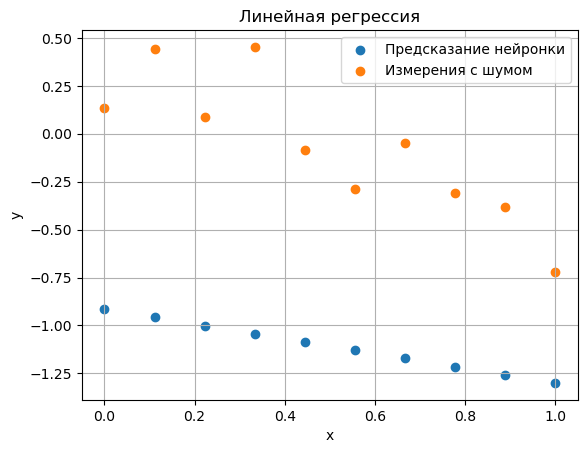

In [242]:
plt.scatter(x.detach().numpy(), sle_pred.detach().numpy(), label='Предсказание нейронки')
plt.scatter(x.detach().numpy(), y.detach().numpy(), label='Измерения с шумом')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Линейная регрессия')
plt.show()

In [255]:
# 1000 - ok, 100 - недообученная получается
for epoch in range(1000):
    loss = torch.mean( torch.abs( y - sle_pred )**2 )
    loss.backward(retain_graph=True)
    optimizer.step()
    sle_pred = sle(x)

In [256]:
#print( sle.fc[0].weight )
#print( sle.fc[0].bias )
print( sle.weight )
print( sle.bias )

Parameter containing:
tensor([[0.2136]], requires_grad=True)
Parameter containing:
tensor([0.1523], requires_grad=True)


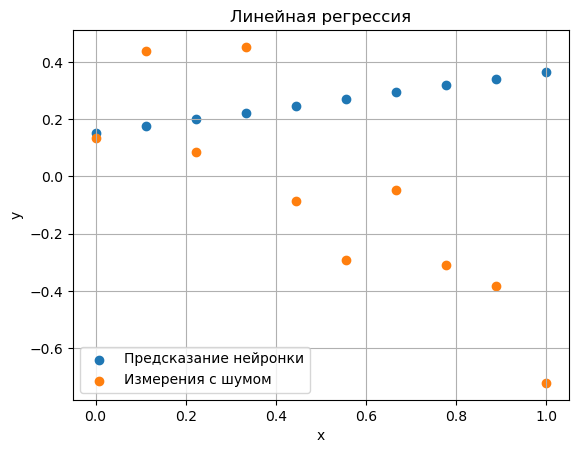

In [257]:
plt.scatter(x.detach().numpy(), sle_pred.detach().numpy(), label='Предсказание нейронки')
plt.scatter(x.detach().numpy(), y.detach().numpy(), label='Измерения с шумом')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Линейная регрессия')
plt.show()

### Опереляем погрешность аппроксимации

In [205]:
# среднее отклонение
torch.mean( torch.abs( y - sle_pred ) )

tensor(0.3693, grad_fn=<MeanBackward0>)

In [206]:
#print( sle.fc[0].weight )
#print( sle.fc[0].bias )
print( sle.weight )
print( sle.bias )

Parameter containing:
tensor([[-0.0439]], requires_grad=True)
Parameter containing:
tensor([0.3383], requires_grad=True)


In [207]:
print(A)
print(B)
print(K_deviation)

-1
0.5
0.2
